In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [8]:
df = pd.read_csv('RELIANCE.csv')
df1 = df.reset_index()['Close']
df1

0        251.70
1        271.85
2        282.50
3        294.35
4        314.55
         ...   
5301    1937.85
5302    1988.65
5303    1997.30
5304    2024.05
5305    1994.50
Name: Close, Length: 5306, dtype: float64

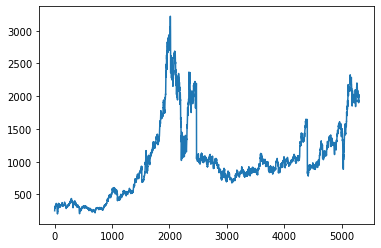

In [9]:
plt.plot(df1)

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.01607211]
 [0.02274949]
 [0.02627873]
 ...
 [0.59453548]
 [0.6034    ]
 [0.59360761]]


In [11]:
##splitting dataset into train and test split
training_size = int(len(df1) * 0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :1]
training_size, test_size

(3448, 1858)

In [12]:
train_data

array([[0.01607211],
       [0.02274949],
       [0.02627873],
       ...,
       [0.23278047],
       [0.23528242],
       [0.23229997]])

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

(3347, 100)
(3347,)
(1757, 100)
(1757,)


(None, None)

In [15]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
53/53 [==============================] - 11s 38ms/step - loss: 0.0123 - val_loss: 0.0012
Epoch 2/100
53/53 [==============================] - 1s 17ms/step - loss: 0.0010 - val_loss: 7.6689e-04
Epoch 3/100
53/53 [==============================] - 1s 18ms/step - loss: 9.0776e-04 - val_loss: 6.8967e-04
Epoch 4/100
53/53 [==============================] - 1s 17ms/step - loss: 8.2672e-04 - val_loss: 6.7485e-04
Epoch 5/100
53/53 [==============================] - 1s 17ms/step - loss: 7.4683e-04 - val_loss: 7.0675e-04
Epoch 6/100
53/53 [==============================] - 1s 18ms/step - loss: 7.1763e-04 - val_loss: 5.8450e-04
Epoch 7/100
53/53 [==============================] - 1s 17ms/step - loss: 6.6200e-04 - val_loss: 6.0534e-04
Epoch 8/100
53/53 [==============================] - 1s 17ms/step - loss: 7.2374e-04 - val_loss: 5.8703e-04
Epoch 9/100
53/53 [==============================] - 1s 17ms/step - loss: 6.1730e-04 - val_loss: 4.5677e-04
Epoch 10/100
53/53 [===================

In [18]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

1123.2066568914806

In [19]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1271.081803480825

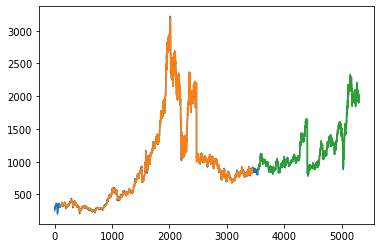

In [21]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [22]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.2143721107484301,
 0.2117210412075622,
 0.21660895067353736,
 0.2205192782463175,
 0.21637698208871142,
 0.215697645518864,
 0.2116713336536709,
 0.21365963580932185,
 0.21264891554686594,
 0.20747932994217355,
 0.2016469769522642,
 0.2013321624442861,
 0.20638576375656553,
 0.2097161698672808,
 0.20593839577154405,
 0.20865574205093368,
 0.21960797309164415,
 0.229284376915812,
 0.2323496760724405,
 0.23836429009328453,
 0.23874538133978424,
 0.24030288469504418,
 0.23980580915613142,
 0.22615280102066176,
 0.2231040710486637,
 0.22419763723427172,
 0.22330290126422875,
 0.2239159610955545,
 0.22272297980216393,
 0.2193760045068182,
 0.2143389723791692,
 0.21843156098288402,
 0.22790913459148676,
 0.22830679502261692,
 0.22436332908057594,
 0.22121518400079532,
 0.22749490497572616,
 0.2295660530545292,
 0.22053584743094795,
 0.2259705399897271,
 0.22368399251072857,
 0.2222756118171425,
 0.2281079648070518,
 0.22943349957748577,
 0.23384090268917868,
 0.22983116000861598,
 0.23218

In [23]:
# demonstrate prediction for next 10 days

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.21172104 0.21660895 0.22051928 ... 0.59453548 0.6034     0.59360761]


ValueError: ignored

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
len(df1)

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)